<a href="https://colab.research.google.com/github/dani2442/2026-Hybrid-Signal-Learning/blob/helon/BAB_NODE_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BAB Dataset: Linear & Nonlinear Models

Organized training and simulation for linear, Stribeck, and black-box models.

In [1]:
!pip install torchdiffeq git+https://github.com/helonayala/bab_datasets.git
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import bab_datasets as nod

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


  Cloning https://github.com/helonayala/bab_datasets.git to /tmp/pip-req-build-dyrlrh8i
  Running command git clone --filter=blob:none --quiet https://github.com/helonayala/bab_datasets.git /tmp/pip-req-build-dyrlrh8i
  Resolved https://github.com/helonayala/bab_datasets.git to commit 45f368bfbfe53838d9834dc3d80474696501e61a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bab_datasets: filename=bab_datasets-0.1.0-py3-none-any.whl size=5784 sha256=7d94cb31bd93a43bf6ad8b3562df9095d1c55cb54e2408e4d2112e48796cba2a
  Stored in directory: /tmp/pip-ephem-wheel-cache-5xchyvaz/wheels/23/a0/ce/e7a4541a3bb5447c58417ab1f537ee233f610bbcfb1784d848
Successfully built bab_datasets
Using device: cuda


## 1) Load Data

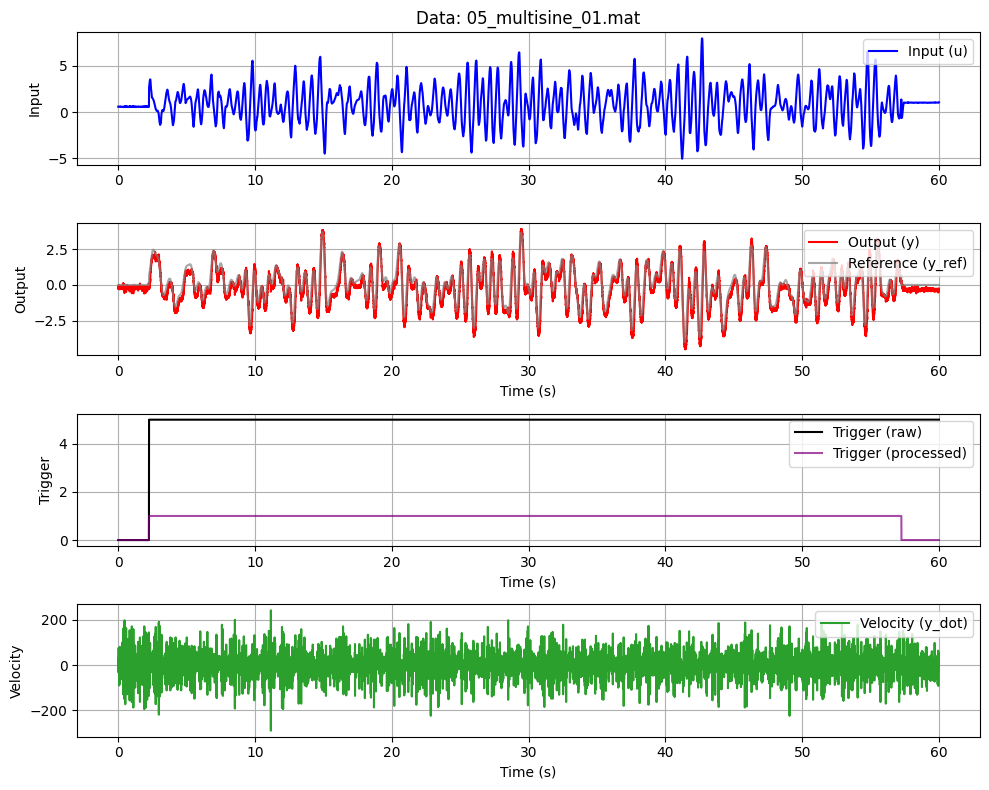

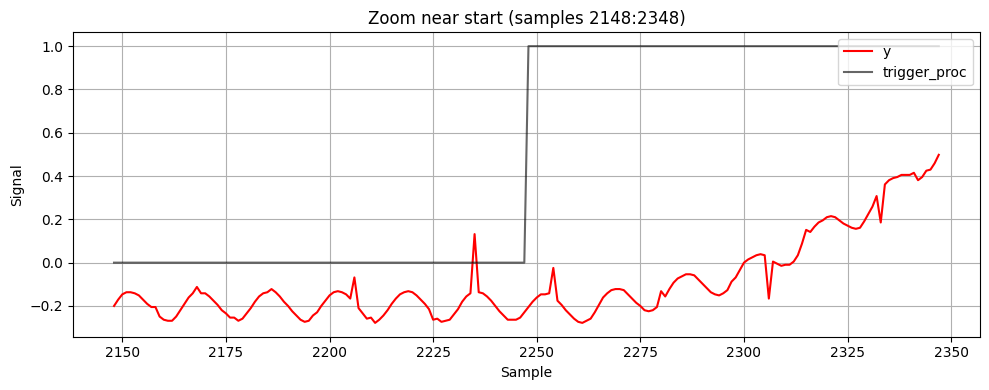

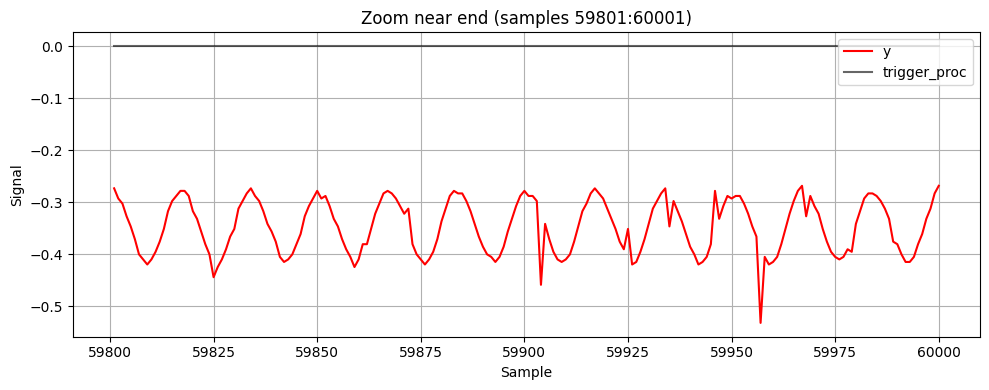

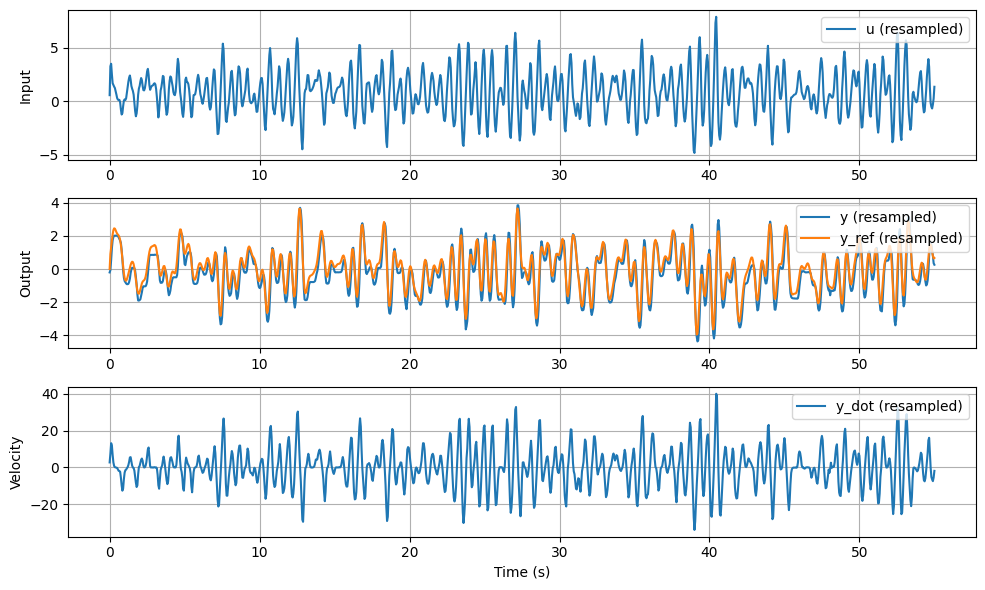

In [2]:
velMethod = "central"

data = nod.load_experiment(
    "multisine_05",
    preprocess=True,
    plot=True,
    end_idx=None,
    resample_factor=50,
    zoom_last_n=200,
    y_dot_method=velMethod,
)

u, y, y_ref, y_dot = data
Ts = data.sampling_time
t = np.arange(len(u)) * Ts

y_sim = np.column_stack([y, y_dot])


## 2) Tensor Prep

In [3]:
t_tensor = torch.tensor(t, dtype=torch.float32).to(device)
u_tensor = torch.tensor(u, dtype=torch.float32).reshape(-1, 1).to(device)
y_tensor = torch.tensor(y_sim, dtype=torch.float32).to(device)


## 3) Model Definitions

In [4]:
class LinearPhysODE(nn.Module):
    # J*thdd + R*thd + K*(th+delta) = Tau*V
    def __init__(self):
        super().__init__()
        self.log_J = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_R = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_K = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))
        self.delta = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.log_Tau = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))
        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def get_params(self):
        J = torch.exp(self.log_J)
        R = torch.exp(self.log_R)
        K = torch.exp(self.log_K)
        Tau = torch.exp(self.log_Tau)
        return J, R, K, self.delta, Tau

    def forward(self, t, x):
        J, R, K, delta, Tau = self.get_params()
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)
        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        th, thd = x[:, 0:1], x[:, 1:2]
        thdd = (Tau * u_t - R * thd - K * (th + delta)) / J
        return torch.cat([thd, thdd], dim=1)


class StribeckPhysODE(nn.Module):
    # J*thdd + R*thd + K*(th+delta) + F_stribeck = Tau*V
    def __init__(self):
        super().__init__()
        self.log_J = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_R = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_K = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))
        self.delta = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.log_Tau = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))

        self.log_Fc = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_Fs = nn.Parameter(torch.tensor(np.log(0.2), dtype=torch.float32))
        self.log_vs = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_b = nn.Parameter(torch.tensor(np.log(0.01), dtype=torch.float32))

        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def get_params(self):
        J = torch.exp(self.log_J)
        R = torch.exp(self.log_R)
        K = torch.exp(self.log_K)
        Tau = torch.exp(self.log_Tau)
        Fc = torch.exp(self.log_Fc)
        Fs = torch.exp(self.log_Fs)
        vs = torch.exp(self.log_vs)
        b = torch.exp(self.log_b)
        return J, R, K, self.delta, Tau, Fc, Fs, vs, b

    def forward(self, t, x):
        J, R, K, delta, Tau, Fc, Fs, vs, b = self.get_params()
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)
        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        th, thd = x[:, 0:1], x[:, 1:2]
        sgn = torch.tanh(thd / 1e-3)
        F_str = (Fc + (Fs - Fc) * torch.exp(-(thd / vs) ** 2)) * sgn + b * thd
        thdd = (Tau * u_t - R * thd - K * (th + delta) - F_str) / J
        return torch.cat([thd, thdd], dim=1)


class BlackBoxODE(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SELU(),
            nn.Linear(hidden_dim // 2, 2)
        )
        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def forward(self, t, x):
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)
        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        nn_input = torch.cat([x, u_t], dim=1)
        return self.net(nn_input)


## 4) Training Helper

In [5]:
def train_model_obs(model, name, epochs=500, lr=0.02, obs_dim=2):
    print(f"--- Training {name} ---")
    model.to(device)
    model.u_series = u_tensor
    model.t_series = t_tensor

    optimizer = optim.Adam(model.parameters(), lr=lr)
    K_STEPS = 20
    BATCH_SIZE = 128
    dt_local = (t_tensor[1] - t_tensor[0]).item()
    t_eval = torch.arange(0, K_STEPS * dt_local, dt_local, device=device)

    for epoch in range(epochs + 1):
        optimizer.zero_grad()
        start_idx = np.random.randint(0, len(t_tensor) - K_STEPS, size=BATCH_SIZE)
        x0 = y_tensor[start_idx]
        model.batch_start_times = t_tensor[start_idx].reshape(-1, 1)

        pred_state = odeint(model, x0, t_eval, method='rk4')
        pred_obs = pred_state[..., :obs_dim]

        batch_targets = []
        for i in start_idx:
            batch_targets.append(y_tensor[i:i + K_STEPS])
        y_target = torch.stack(batch_targets, dim=1)

        loss = torch.mean((pred_obs - y_target) ** 2)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

    return model


## 5) Train Linear Model

In [6]:
lin_model = LinearPhysODE()
lin_model = train_model_obs(lin_model, "Linear Model", epochs=1000, lr=0.01)


--- Training Linear Model ---
Epoch 0 | Loss: 57.663128
Epoch 100 | Loss: 8.343981
Epoch 200 | Loss: 3.228567
Epoch 300 | Loss: 2.327902
Epoch 400 | Loss: 1.912454
Epoch 500 | Loss: 1.830005
Epoch 600 | Loss: 1.600957
Epoch 700 | Loss: 1.496830
Epoch 800 | Loss: 1.494463
Epoch 900 | Loss: 1.456620
Epoch 1000 | Loss: 1.482978


## 6) Train Stribeck Model

In [7]:
str_model = StribeckPhysODE()
str_model = train_model_obs(str_model, "Stribeck Model", epochs=1000, lr=0.01)


--- Training Stribeck Model ---
Epoch 0 | Loss: 58.919140
Epoch 100 | Loss: 7.098650
Epoch 200 | Loss: 3.633652
Epoch 300 | Loss: 2.488712
Epoch 400 | Loss: 2.016912
Epoch 500 | Loss: 1.432277
Epoch 600 | Loss: 1.206366
Epoch 700 | Loss: 1.119539
Epoch 800 | Loss: 1.353761
Epoch 900 | Loss: 0.927816
Epoch 1000 | Loss: 0.759707


## 7) Train Black-box Model

In [8]:
bb_model = BlackBoxODE(hidden_dim=128)
bb_model = train_model_obs(bb_model, "Black-Box Model", epochs=1000, lr=0.01)


--- Training Black-Box Model ---
Epoch 0 | Loss: 120.485146
Epoch 100 | Loss: 0.969485
Epoch 200 | Loss: 0.714460
Epoch 300 | Loss: 0.360356
Epoch 400 | Loss: 0.373944
Epoch 500 | Loss: 0.303038
Epoch 600 | Loss: 0.330221
Epoch 700 | Loss: 0.253253
Epoch 800 | Loss: 0.277954
Epoch 900 | Loss: 0.240043
Epoch 1000 | Loss: 0.234653


## 8) Simulate Linear Model

In [9]:
with torch.no_grad():
    lin_model.batch_start_times = torch.zeros(1, 1).to(device)
    x0 = y_tensor[0].unsqueeze(0)
    pred_lin = odeint(lin_model, x0, t_tensor, method='rk4').squeeze(1).cpu().numpy()


## 9) Simulate Stribeck Model

In [10]:
with torch.no_grad():
    str_model.batch_start_times = torch.zeros(1, 1).to(device)
    x0 = y_tensor[0].unsqueeze(0)
    pred_str = odeint(str_model, x0, t_tensor, method='rk4').squeeze(1).cpu().numpy()


## 10) Simulate Black-box Model

In [11]:
with torch.no_grad():
    bb_model.batch_start_times = torch.zeros(1, 1).to(device)
    x0 = y_tensor[0].unsqueeze(0)
    pred_bb = odeint(bb_model, x0, t_tensor, method='rk4').squeeze(1).cpu().numpy()


## 11) Comparison Plots

Metrics - Position
Model        RMSE      R2        FIT%
Linear       0.5255    0.8536   61.74   
Stribeck     0.4785    0.8786   65.16   
Black-box    0.2967    0.9533   78.40   
Metrics - Velocity
Model        RMSE      R2        FIT%
Linear       1.7310    0.9738   83.81   
Stribeck     1.3452    0.9842   87.42   
Black-box    0.6766    0.9960   93.67   


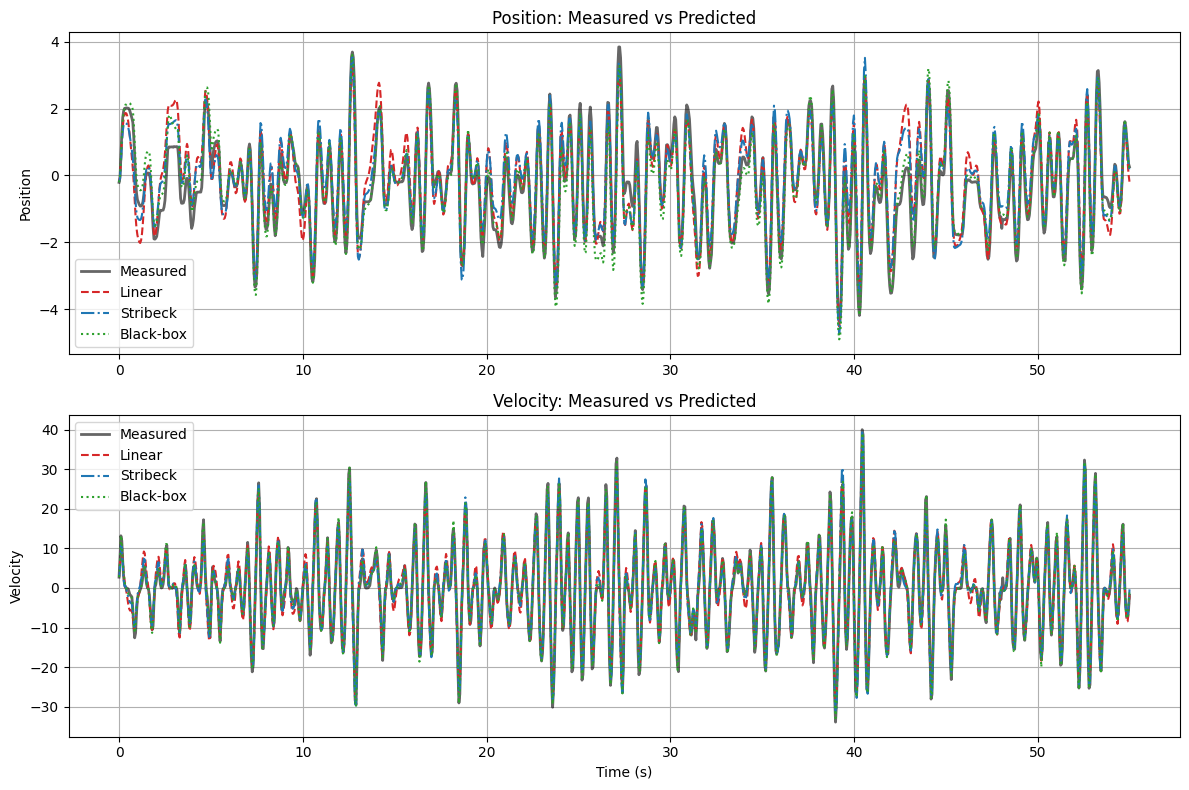

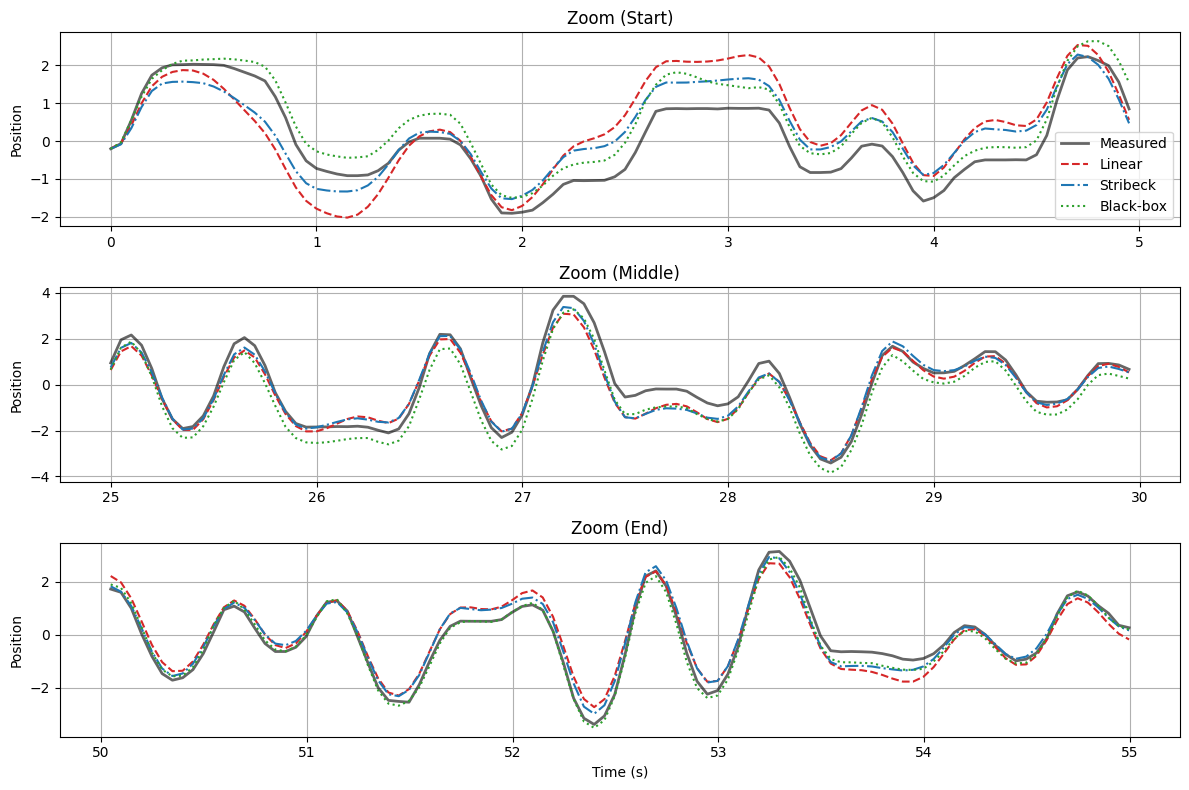

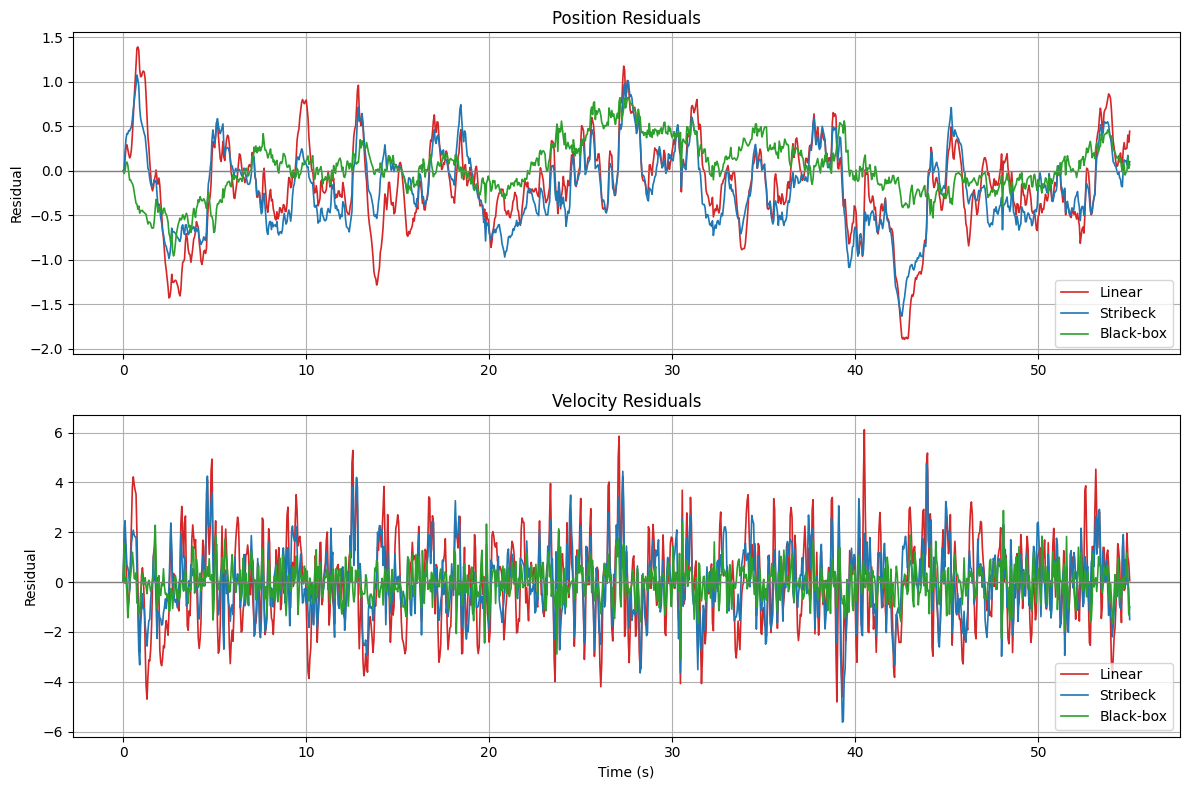

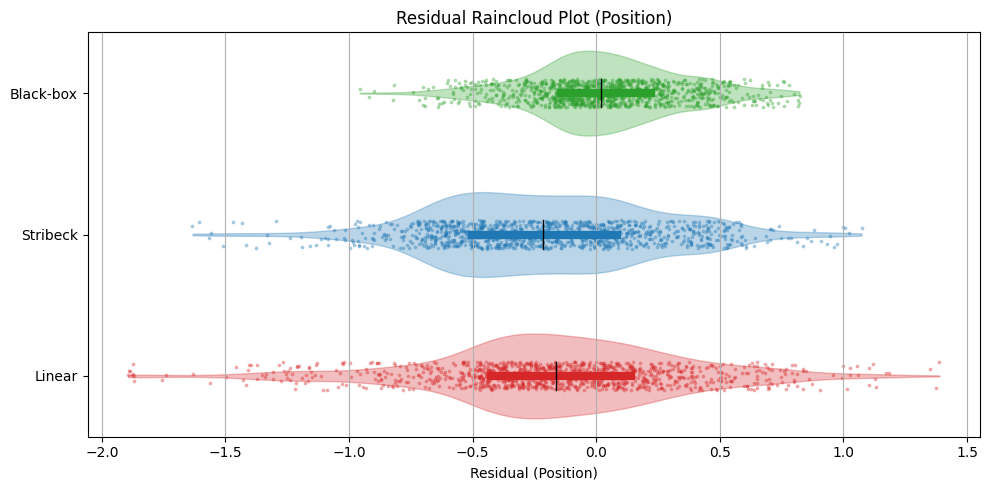

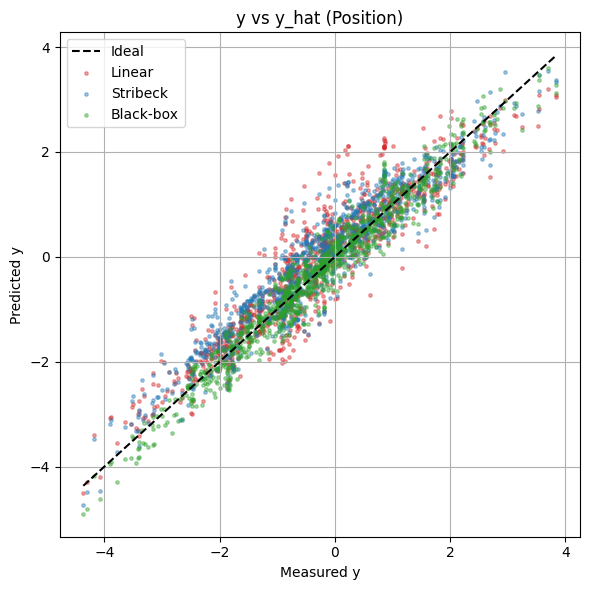

In [12]:
# Metrics and residuals for all models
models = {
    "Linear": pred_lin,
    "Stribeck": pred_str,
    "Black-box": pred_bb,
}
colors = {
    "Linear": "tab:red",
    "Stribeck": "tab:blue",
    "Black-box": "tab:green",
}
styles = {
    "Linear": "--",
    "Stribeck": "-.",
    "Black-box": ":",
}

residuals = {}
metrics = {}
for name, pred in models.items():
    res_pos = y_sim[:, 0] - pred[:, 0]
    res_vel = y_sim[:, 1] - pred[:, 1]
    rmse_pos = np.sqrt(np.mean(res_pos**2))
    rmse_vel = np.sqrt(np.mean(res_vel**2))
    ss_res_pos = np.sum(res_pos**2)
    ss_tot_pos = np.sum((y_sim[:, 0] - np.mean(y_sim[:, 0]))**2)
    ss_res_vel = np.sum(res_vel**2)
    ss_tot_vel = np.sum((y_sim[:, 1] - np.mean(y_sim[:, 1]))**2)
    r2_pos = 1 - ss_res_pos / ss_tot_pos if ss_tot_pos > 0 else np.nan
    r2_vel = 1 - ss_res_vel / ss_tot_vel if ss_tot_vel > 0 else np.nan
    fit_pos = 100 * (1 - np.linalg.norm(res_pos) / np.linalg.norm(y_sim[:, 0] - np.mean(y_sim[:, 0])))
    fit_vel = 100 * (1 - np.linalg.norm(res_vel) / np.linalg.norm(y_sim[:, 1] - np.mean(y_sim[:, 1])))
    residuals[name] = {"pos": res_pos, "vel": res_vel}
    metrics[name] = {"rmse_pos": rmse_pos, "rmse_vel": rmse_vel, "r2_pos": r2_pos, "r2_vel": r2_vel, "fit_pos": fit_pos, "fit_vel": fit_vel}

# Metrics tables
print("Metrics - Position")
print("Model        RMSE      R2        FIT%")
for name in models.keys():
    m = metrics[name]
    print(f"{name:<12} {m['rmse_pos']:<9.4f} {m['r2_pos']:<8.4f} {m['fit_pos']:<8.2f}")

print("Metrics - Velocity")
print("Model        RMSE      R2        FIT%")
for name in models.keys():
    m = metrics[name]
    print(f"{name:<12} {m['rmse_vel']:<9.4f} {m['r2_vel']:<8.4f} {m['fit_vel']:<8.2f}")

# Comparison plots (no metrics in titles)
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, y_sim[:, 0], 'k-', alpha=0.6, linewidth=2, label='Measured')
for name, pred in models.items():
    plt.plot(t, pred[:, 0], linestyle=styles[name], color=colors[name], linewidth=1.5, label=name)
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.title("Position: Measured vs Predicted")

plt.subplot(2, 1, 2)
plt.plot(t, y_sim[:, 1], 'k-', alpha=0.6, linewidth=2, label='Measured')
for name, pred in models.items():
    plt.plot(t, pred[:, 1], linestyle=styles[name], color=colors[name], linewidth=1.5, label=name)
plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.legend()
plt.grid(True)
plt.title("Velocity: Measured vs Predicted")

plt.tight_layout()
plt.show()

# Zooms (position only)
win_sec = 5.0
win_n = int(win_sec / Ts)
starts = [0, max(0, (len(t) - win_n) // 2), max(0, len(t) - win_n)]
labels = ["Start", "Middle", "End"]

plt.figure(figsize=(12, 8))
for i, s in enumerate(starts):
    e = min(len(t), s + win_n)
    plt.subplot(3, 1, i + 1)
    plt.plot(t[s:e], y_sim[s:e, 0], 'k-', alpha=0.6, linewidth=2, label='Measured')
    for name, pred in models.items():
        plt.plot(t[s:e], pred[s:e, 0], linestyle=styles[name], color=colors[name], linewidth=1.5, label=name)
    plt.title(f"Zoom ({labels[i]})")
    plt.ylabel('Position')
    plt.grid(True)
    if i == 0:
        plt.legend()
    if i == 2:
        plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

# Residuals (all models)
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
for name in models.keys():
    plt.plot(t, residuals[name]['pos'], color=colors[name], linewidth=1.2, label=name)
plt.axhline(0, color='gray', linewidth=1)
plt.title('Position Residuals')
plt.ylabel('Residual')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
for name in models.keys():
    plt.plot(t, residuals[name]['vel'], color=colors[name], linewidth=1.2, label=name)
plt.axhline(0, color='gray', linewidth=1)
plt.title('Velocity Residuals')
plt.ylabel('Residual')
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Raincloud plot (position residuals)
from scipy.stats import gaussian_kde

labels = list(models.keys())
res_list = [residuals[name]['pos'] for name in labels]

plt.figure(figsize=(10, 5))
for i, (label, res) in enumerate(zip(labels, res_list)):
    res = res[np.isfinite(res)]
    kde = gaussian_kde(res)
    xs = np.linspace(np.min(res), np.max(res), 200)
    ys = kde(xs)
    ys = ys / ys.max() * 0.3
    plt.fill_between(xs, i + ys, i - ys, color=colors[label], alpha=0.3)
    q1, q2, q3 = np.percentile(res, [25, 50, 75])
    plt.plot([q1, q3], [i, i], color=colors[label], linewidth=6)
    plt.plot([q2, q2], [i-0.1, i+0.1], color='k', linewidth=1)
    jitter = (np.random.rand(len(res)) - 0.5) * 0.2
    plt.scatter(res, i + jitter, s=3, color=colors[label], alpha=0.3)

plt.yticks(range(len(labels)), labels)
plt.xlabel('Residual (Position)')
plt.title('Residual Raincloud Plot (Position)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

# y vs yhat (position)
plt.figure(figsize=(6, 6))
plt.plot([y_sim[:,0].min(), y_sim[:,0].max()], [y_sim[:,0].min(), y_sim[:,0].max()], 'k--', label='Ideal')
for name, pred in models.items():
    plt.scatter(y_sim[:,0], pred[:,0], s=6, alpha=0.4, color=colors[name], label=name)
plt.xlabel('Measured y')
plt.ylabel('Predicted y')
plt.title('y vs y_hat (Position)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 12) Diagnostics (Position)

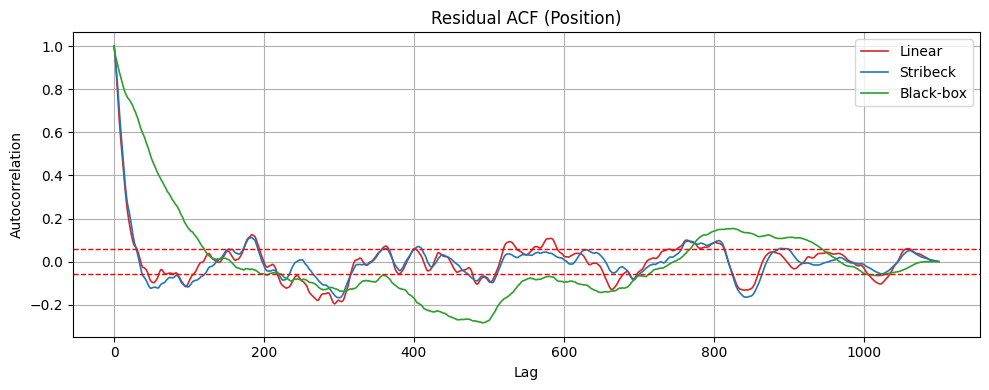

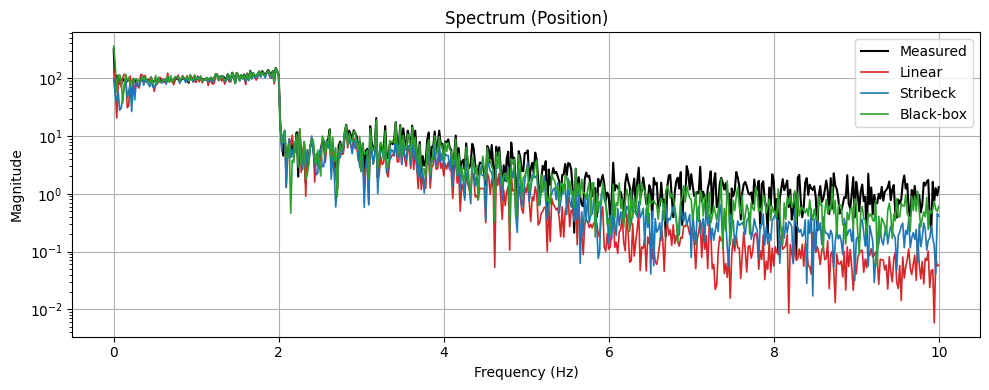

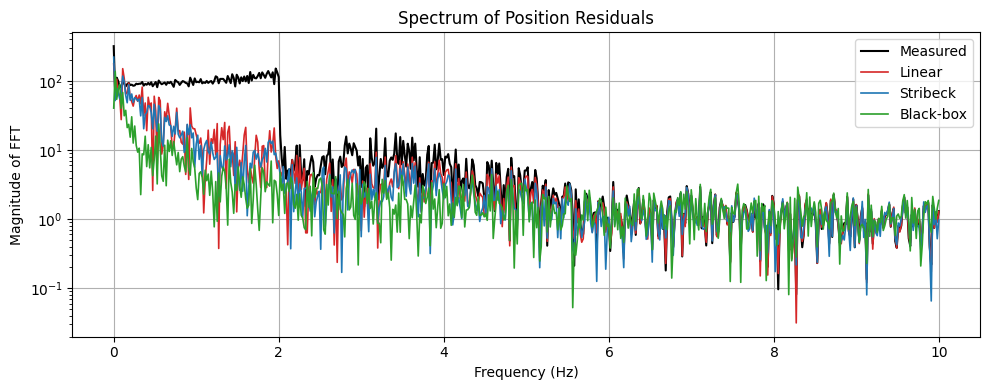

In [15]:
# Residual ACF (position) for all models
N = len(t)
max_lag = min(2000, N - 1)
conf = 1.96 / np.sqrt(N)

plt.figure(figsize=(10, 4))
for name in models.keys():
    res = residuals[name]['pos'] - np.mean(residuals[name]['pos'])
    acf = np.correlate(res, res, mode='full')
    acf = acf[N-1:N+max_lag] / acf[N-1]
    plt.plot(np.arange(0, max_lag+1), acf, color=colors[name], linewidth=1.2, label=name)

plt.axhline(conf, color='red', linestyle='--', linewidth=1)
plt.axhline(-conf, color='red', linestyle='--', linewidth=1)
plt.title('Residual ACF (Position)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Spectrum: measured vs predictions (position)
freqs = np.fft.rfftfreq(len(t), d=Ts)
Y_meas = np.fft.rfft(y_sim[:, 0])

plt.figure(figsize=(10, 4))
plt.semilogy(freqs, np.abs(Y_meas), color='k', label='Measured')
for name, pred in models.items():
    Y_pred = np.fft.rfft(pred[:, 0])
    plt.semilogy(freqs, np.abs(Y_pred), color=colors[name], linewidth=1.2, label=name)
plt.title('Spectrum (Position)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Spectrum of position residuals for all models
plt.figure(figsize=(10, 4))
plt.semilogy(freqs, np.abs(Y_meas), color='k', label='Measured')
for name in models.keys():
    # Calculate FFT of position residuals
    res_fft = np.fft.rfft(residuals[name]['pos'])
    # Plot magnitude spectrum on a semilogy scale
    plt.semilogy(freqs, np.abs(res_fft), color=colors[name], linewidth=1.2, label=name)

plt.title('Spectrum of Position Residuals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude of FFT')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()